In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import os

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, roc_auc_score, log_loss
import lightgbm as lgb

from scipy.stats import ks_2samp
import pickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

In [2]:
# Import trainning data
train_df = pd.read_csv('C:\\Users\\doris\\Documents\\Julian\\Analytics_and_Data_Science\\Python\\titanic\\data\\train.csv').rename(columns=str.lower)
train_df.shape 
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 315.0 KB


"""
Target: 
      survival 0=No / 1=Yes 
Features:
      pclass Ticket Class 1 = 1st, 2 = 2nd, 3 = 3rd
      sex
      age
      sibsp  # of siblings / spouses aboard the Titanic
      parch  # of parents / children aboard the Titanic
      ticket Ticket number
      fare   Passenger fare
      embarked  Port of Embarkation  C = Cherbourg, Q = Queenstown, S = Southampton

"""

In [3]:
train_df.isnull().sum()  #177 null in age, 687 null in cabin, 2 null in embarked

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [4]:
# define a function to explore the missing rate
def explor_missing(data, dropna=True):
      data_na = (data.isnull().sum() / len(data))*100
      if dropna == True:
            data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
      else:
            data_na = data_na.sort_values(ascending=False)
      missing_info = pd.DataFrame({'Missing Ratio' : data_na})
      return missing_info

missing_info = explor_missing(train_df, dropna=False)
print(missing_info)

             Missing Ratio
cabin            77.104377
age              19.865320
embarked          0.224467
fare              0.000000
ticket            0.000000
parch             0.000000
sibsp             0.000000
sex               0.000000
name              0.000000
pclass            0.000000
survived          0.000000
passengerid       0.000000


In [5]:
train_df.dtypes[train_df.dtypes == 'object']

name        object
sex         object
ticket      object
cabin       object
embarked    object
dtype: object

In [6]:
list(train_df.dtypes[train_df.dtypes == 'object'].index)

['name', 'sex', 'ticket', 'cabin', 'embarked']

In [7]:
#split data into numeric and character variables
var_cols = list(train_df.dtypes[train_df.dtypes == 'object'].index)
df_num = train_df.drop(var_cols, axis=1)
df_char = train_df[var_cols]

In [8]:
print(df_num.shape)

(891, 7)


In [9]:
print(df_char.shape)

(891, 5)


In [10]:
# find the abnormal categorical varibles
df_char.describe()   

,name,sex,ticket,cabin,embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Morrow, Mr. Thomas Rowan",male,1601,B96 B98,S
freq,1,577,7,4,644


In [11]:
# name has too many unique values, need special handling
for col in df_char.columns:
      if len(df_char[col].unique()) > 10:
            print("Var {}, there are {} unique values, need to be manually transformed later.".format(col,str(len(df_char[col].unique()))))

Var name, there are 891 unique values, need to be manually transformed later.
Var ticket, there are 681 unique values, need to be manually transformed later.
Var cabin, there are 148 unique values, need to be manually transformed later.


In [12]:
# explore the relationship between response and categorial variables      
for col in df_char.columns:
      if col in ['sex', 'embarked']:
            print(col)
            print(pd.crosstab(train_df[col], train_df.survived, normalize = 'index'))
            print('==============='*5)

sex
survived         0         1
sex                         
female    0.257962  0.742038
male      0.811092  0.188908
embarked
survived         0         1
embarked                    
C         0.446429  0.553571
Q         0.610390  0.389610
S         0.663043  0.336957


In [13]:
df_num.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
num_unique = []

for col in list(df_num.columns):
      n_unique = len(df_num[col].unique())
      num_unique.append([col, n_unique])

In [15]:
pd.DataFrame(num_unique).rename(columns={0:'col', 1:'uni_value'}).sort_values('uni_value').head(10) 

,col,uni_value
1,survived,2
2,pclass,3
4,sibsp,7
5,parch,7
3,age,89
6,fare,248
0,passengerid,891


In [16]:
for col in df_num.columns:
      if col in ['pclass', 'sibsp','parch']:
            print(col)
            print(pd.crosstab(train_df[col], train_df.survived, normalize = 'index'))
            print('==============='*5)

pclass
survived         0         1
pclass                      
1         0.370370  0.629630
2         0.527174  0.472826
3         0.757637  0.242363
sibsp
survived         0         1
sibsp                       
0         0.654605  0.345395
1         0.464115  0.535885
2         0.535714  0.464286
3         0.750000  0.250000
4         0.833333  0.166667
5         1.000000  0.000000
8         1.000000  0.000000
parch
survived         0         1
parch                       
0         0.656342  0.343658
1         0.449153  0.550847
2         0.500000  0.500000
3         0.400000  0.600000
4         1.000000  0.000000
5         0.800000  0.200000
6         1.000000  0.000000


### imputing character variables

In [17]:
df_char.describe()

,name,sex,ticket,cabin,embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Morrow, Mr. Thomas Rowan",male,1601,B96 B98,S
freq,1,577,7,4,644


In [18]:
df_char.isnull().sum() 

name          0
sex           0
ticket        0
cabin       687
embarked      2
dtype: int64

In [19]:
def fill_na_cat(data):
      df_freq = data.describe()
      for col in list(data.columns):
            if len(data[col].unique()) <= 50:
                  data[col] = data[col].fillna(data[col].mode()[0])
      return data

df_char_fillna = fill_na_cat(df_char).copy()

df_char_fillna.isnull().sum() 

name          0
sex           0
ticket        0
cabin       687
embarked      0
dtype: int64

In [20]:
df_num.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [21]:
def fill_na_num(data):
      df_freq = data.describe()
      for col in list(data.columns):
            if len(data[col].unique()) >= 50:
                  data[col] = data[col].fillna(data[col].median())
            else:
                  data[col] = data[col].fillna(0)
      return data      
      
df_num_fillna = fill_na_num(df_num)         

In [22]:
print("# of missing value in numerical var is {}".format(df_num.isnull().sum().max()))             
print("# of missing value in categorical var is {}".format(df_char_fillna.isnull().sum().max()))     

# of missing value in numerical var is 0
# of missing value in categorical var is 687


In [23]:
train_df = pd.concat([df_num, df_char_fillna],axis=1)
print(train_df.shape)   

(891, 12)


In [24]:
train_df.head()

,passengerid,survived,pclass,age,sibsp,parch,fare,name,sex,ticket,cabin,embarked
0,1,0,3,22.0,1,0,7.2500,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,2,1,1,38.0,1,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,3,1,3,26.0,0,0,7.9250,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,4,1,1,35.0,1,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,5,0,3,35.0,0,0,8.0500,"Allen, Mr. William Henry",male,373450,NaN,S


In [25]:
# create new feature title

train_df['title'] = train_df.name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df['title'], train_df['sex'])

train_df['title'] = train_df['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train_df['title'] = train_df['title'].replace('Mlle', 'Miss')
train_df['title'] = train_df['title'].replace('Ms', 'Miss')
train_df['title'] = train_df['title'].replace('Mme', 'Mrs')

train_df[['title', 'survived']].groupby(['title'], as_index=False).mean()

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

train_df['title'] = train_df['title'].map(title_mapping).astype(int)
train_df['title'] = train_df['title'].fillna(0)

train_df = train_df.drop(['name'], axis=1)

train_df.head()

,passengerid,survived,pclass,age,sibsp,parch,fare,sex,ticket,cabin,embarked,title
0,1,0,3,22.0,1,0,7.2500,male,A/5 21171,NaN,S,1
1,2,1,1,38.0,1,0,71.2833,female,PC 17599,C85,C,3
2,3,1,3,26.0,0,0,7.9250,female,STON/O2. 3101282,NaN,S,2
3,4,1,1,35.0,1,0,53.1000,female,113803,C123,S,3
4,5,0,3,35.0,0,0,8.0500,male,373450,NaN,S,1


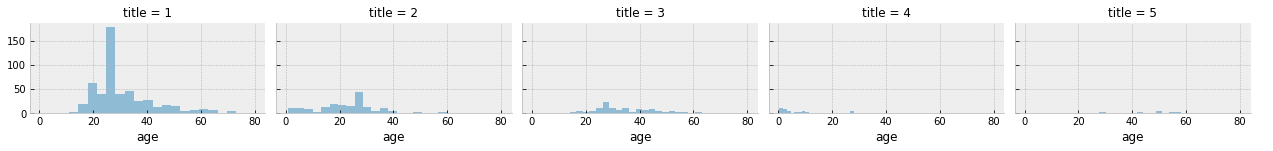

In [26]:
grid = sns.FacetGrid(train_df, col='title', size=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend()
plt.show()

In [27]:
guess_ages = np.zeros(5)
guess_ages

array([0., 0., 0., 0., 0.])

In [28]:
# Special Handling for Imputing missing age
for i in range(5):
            guess_df = train_df[train_df['title'] == i+1]['age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i] = int( age_guess/0.5 + 0.5 ) * 0.5 # Convert random age float to nearest .5 age

In [29]:
guess_ages

array([28. , 24. , 32.5,  4. , 48. ])

In [30]:
# Special Handling for Imputing missing age

for i in range(5):
            train_df.loc[(train_df.age.isnull()) & (train_df.title == i+1) ,'age'] = guess_ages[i]

train_df['age'] = train_df['age'].astype(int)

train_df.isnull().sum() 



passengerid      0
survived         0
pclass           0
age              0
sibsp            0
parch            0
fare             0
sex              0
ticket           0
cabin          687
embarked         0
title            0
dtype: int64

In [31]:
train_df.head()

,passengerid,survived,pclass,age,sibsp,parch,fare,sex,ticket,cabin,embarked,title
0,1,0,3,22,1,0,7.2500,male,A/5 21171,NaN,S,1
1,2,1,1,38,1,0,71.2833,female,PC 17599,C85,C,3
2,3,1,3,26,0,0,7.9250,female,STON/O2. 3101282,NaN,S,2
3,4,1,1,35,1,0,53.1000,female,113803,C123,S,3
4,5,0,3,35,0,0,8.0500,male,373450,NaN,S,1


In [32]:
# drop passengerid cabin and ticket
train_df = train_df.drop(['passengerid', 'cabin','ticket'],axis=1)

In [33]:
train_df.head()

,survived,pclass,age,sibsp,parch,fare,sex,embarked,title
0,0,3,22,1,0,7.2500,male,S,1
1,1,1,38,1,0,71.2833,female,C,3
2,1,3,26,0,0,7.9250,female,S,2
3,1,1,35,1,0,53.1000,female,S,3
4,0,3,35,0,0,8.0500,male,S,1


In [34]:
train_df['ageband'] = pd.cut(train_df['age'], 5)
train_df[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean().sort_values(by='ageband', ascending=True)


,ageband,survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.344762
2,"(32.0, 48.0]",0.403226
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [35]:
# bin age into 5 groups

train_df['ageband'] = pd.cut(train_df['age'], 5)
train_df[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean().sort_values(by='ageband', ascending=True)

train_df.loc[ train_df['age'] <= 16, 'age2'] = 0
train_df.loc[(train_df['age'] > 16) & (train_df['age'] <= 32), 'age2'] = 1
train_df.loc[(train_df['age'] > 32) & (train_df['age'] <= 48), 'age2'] = 2
train_df.loc[(train_df['age'] > 48) & (train_df['age'] <= 64), 'age2'] = 3
train_df.loc[train_df['age'] > 64, 'age2'] = 4
train_df.head()

train_df['age2'].value_counts(dropna=False)
train_df[['age2', 'survived']].groupby(['age2'], as_index=False).mean().sort_values(by='age2', ascending=True)

train_df = train_df.drop(['age','ageband'],axis=1)
train_df = train_df.rename(columns={"age2": "age"})
train_df['age'] = train_df['age'].astype(int)
train_df.head()

,survived,pclass,sibsp,parch,fare,sex,embarked,title,age
0,0,3,1,0,7.2500,male,S,1,1
1,1,1,1,0,71.2833,female,C,3,2
2,1,3,0,0,7.9250,female,S,2,1
3,1,1,1,0,53.1000,female,S,3,2
4,0,3,0,0,8.0500,male,S,1,2


In [36]:
# bin fare into 4 groups
train_df['fareband'] = pd.qcut(train_df['fare'], 4)
train_df[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean().sort_values(by='fareband', ascending=True)


,fareband,survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [37]:
# bin fare into 4 groups
train_df['fareband'] = pd.qcut(train_df['fare'], 4)
train_df[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean().sort_values(by='fareband', ascending=True)

train_df.loc[ train_df['fare'] <= 7.91, 'fare2'] = 0
train_df.loc[(train_df['fare'] > 7.91) & (train_df['fare'] <= 14.454), 'fare2'] = 1
train_df.loc[(train_df['fare'] > 14.454) & (train_df['fare'] <= 31), 'fare2'] = 2
train_df.loc[train_df['fare'] > 31, 'fare2'] = 3
train_df.head()

train_df['fare2'].value_counts(dropna=False)
train_df[['fare2', 'survived']].groupby(['fare2'], as_index=False).mean().sort_values(by='fare2', ascending=True)

train_df = train_df.drop(['fare','fareband'],axis=1)
train_df = train_df.rename(columns={"fare2": "fare"})
train_df['fare'] = train_df['fare'].astype(int)

In [38]:
# create new feature familiy size and isalone

train_df['familysize'] = train_df['sibsp'] + train_df['parch'] + 1
train_df[['familysize', 'survived']].groupby(['familysize'], as_index=False).mean().sort_values(by='survived', ascending=False)

train_df.loc[train_df['familysize'] == 1, 'isalone'] = 1      
train_df.loc[train_df['familysize'] != 1, 'isalone'] = 0
train_df['isalone'] = train_df['isalone'].astype(int)
# isalone is more meanningful
train_df[['isalone', 'survived']].groupby(['isalone'], as_index=False).mean().sort_values(by='survived', ascending=False)

train_df = train_df.drop(['parch', 'sibsp', 'familysize'], axis=1)

In [39]:
# class*age

train_df['class*age'] = train_df['pclass']*train_df['age']   
train_df['class*age'] = train_df['class*age'].astype(int)

train_df.loc[:, ['class*age', 'age', 'pclass']].head(10)

# transform embark
train_df['embarked'] = train_df['embarked'].map( {'S': 0, 'C': 1, 'Q' : 2} ).astype(int)
# transform sex
train_df['sex'] = train_df['sex'].map( {'male': 0, 'female': 1} ).astype(int)

In [40]:
train_df.isnull().sum() 

survived     0
pclass       0
sex          0
embarked     0
title        0
age          0
fare         0
isalone      0
class*age    0
dtype: int64

In [41]:
train_df.shape

(891, 9)

In [42]:
train_df.head(10)

,survived,pclass,sex,embarked,title,age,fare,isalone,class*age
0,0,3,0,0,1,1,0,0,3
1,1,1,1,1,3,2,3,0,2
2,1,3,1,0,2,1,1,1,3
3,1,1,1,0,3,2,3,0,2
4,0,3,0,0,1,2,1,1,6
5,0,3,0,2,1,1,1,1,3
6,0,1,0,0,1,3,3,1,3
7,0,3,0,0,4,0,2,0,0
8,1,3,1,0,3,1,1,0,3
9,1,2,1,1,3,0,2,0,0


In [43]:
# Feature Importance
X_data = train_df.drop('survived', axis=1)
Y_data = train_df['survived']

rf = RandomForestClassifier()
rf.fit(X_data, Y_data)
fi= pd.DataFrame({'feature':X_data.columns, 'fi':list(rf.feature_importances_)}).sort_values('fi',ascending=False).reset_index(drop=True)
fi['fi_cumsum'] = np.cumsum(fi['fi'])
print(fi)

     feature        fi  fi_cumsum
0      title  0.286713   0.286713
1        sex  0.195109   0.481822
2     pclass  0.132424   0.614246
3       fare  0.126763   0.741010
4  class*age  0.097630   0.838640
5   embarked  0.070569   0.909209
6        age  0.053226   0.962435
7    isalone  0.037565   1.000000


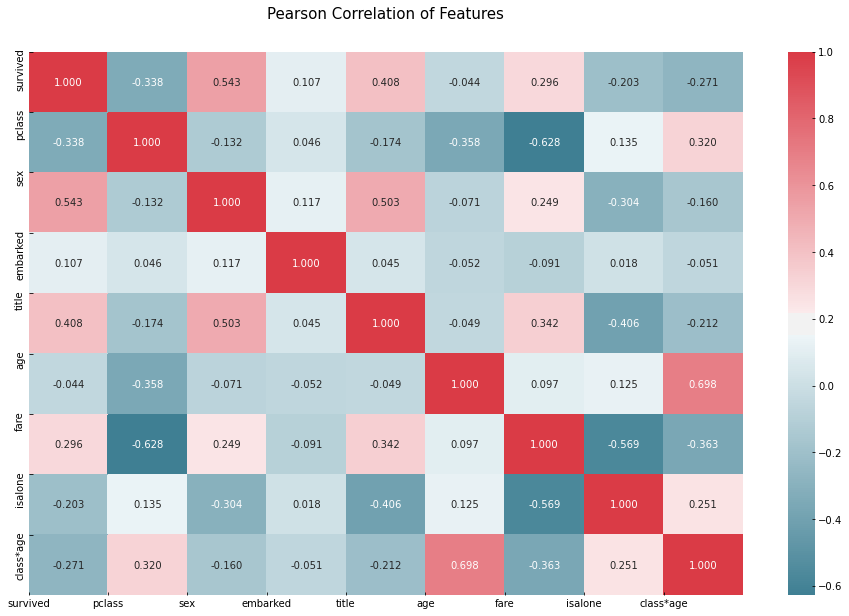

In [44]:
def correlation_heatmap(df):
        corr = df.corr()
        fig, ax = plt.subplots(figsize=(16,10))
        colormap = sns.diverging_palette(220,10,as_cmap=True)
        sns.heatmap(corr,cmap=colormap, annot=True,fmt=".3f")
        plt.xticks(range(len(corr.columns)), corr.columns);
        plt.yticks(range(len(corr.columns)), corr.columns)       
        plt.title('Pearson Correlation of Features', y=1.05, size=15)
        plt.show()

correlation_heatmap(train_df)

In [45]:
train_df.to_csv('C:\\Users\\doris\\Documents\\Julian\\Analytics_and_Data_Science\\Python\\Titanic\\data\\train_df.csv', index=False)